In [1]:
from __init__ import PRP; import sys
sys.path.append(PRP + 'veros/')

from datetime import datetime
from jax import config
config.update("jax_enable_x64", True)

import jax
sys.path.append(PRP)

from scripts.load_runtime import * #Setup parameters for veros 
from setups.acc.acc_learning import ACCSetup

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'

import jax.numpy as jnp
import pandas as pd

Differentiable Veros Experimental version
Importing core modules
 Using computational backend jax on cpu
  Kernels are compiled during first iteration, be patient
 Runtime settings are now locked



# Spin-up 

In [3]:
# Spin-up 
warmup_steps = 200
acc = ACCSetup()
acc.setup()


def ps(state) : 
    print('Compile')
    n_state = state.copy()
    acc.step(n_state)
    return n_state

# Spin-up 
acc = ACCSetup()
acc.setup()

step_jit = jax.jit(ps)

state = acc.state.copy()
for step in tqdm(range(warmup_steps)) :
    state = step_jit(state)

Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075
Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075


  0%|                                                                                         | 0/200 [00:00<?, ?it/s]

Compile


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 51.83it/s]


# Compute gradients

## Gradients w.r.t initial state

In [4]:
psj = jax.checkpoint(ps)

In [5]:
def agg_sum(state, key_sum = 'temp') :
    tau = getattr(state.variables, 'tau')
    return ((getattr(state.variables, key_sum))**2).sum()

def loss_fn(x, ps_fun, agg_fun, n_iter=5) : 
    for i in range(n_iter) :
        x = ps_fun(x)
    return agg_fun(x)

In [8]:
loss_and_grad = jax.value_and_grad(loss_fn, argnums=0, allow_int=True)

In [10]:
%%time
loss, grad = loss_and_grad(state, psj, agg_sum, n_iter=100)
jax.block_until_ready((loss, grad));

CPU times: user 17.5 s, sys: 1.62 s, total: 19.1 s
Wall time: 7.31 s


## Compute gradient w.r.t correction

In [11]:
def corr(x, theta) : 
    x = x.copy()
    with x.variables.unlock()  :
        x.variables.temp *= theta
    return x

def loss_fn_theta(x, theta, ps_fun, agg_fun, corr_fun, n_iter=5) : 
    for i in range(n_iter) :
        x = ps_fun(x)
        x = corr_fun(x, theta)
    return agg_fun(x)

In [12]:
loss_and_grad_theta = jax.value_and_grad(loss_fn_theta, argnums=1)

In [13]:
theta = jnp.array([1.0001])

In [15]:
%%time
loss, grad = loss_and_grad_theta(state, theta, psj, agg_sum, corr, n_iter=10)


CPU times: user 1.28 s, sys: 123 ms, total: 1.4 s
Wall time: 656 ms


In [16]:
%%time
loss, grad = loss_and_grad_theta(state, theta, psj, agg_sum, corr, n_iter=1000)

CPU times: user 2min 25s, sys: 19 s, total: 2min 44s
Wall time: 1min 33s


In [138]:
# Evaluating the difference between numerical diff and gradients for theta
grads = []
for n_iter in tqdm(range(1, 52,10)) :
    loss, grad = loss_and_grad_theta(state, theta, psj, agg_sum, corr, n_iter=n_iter)
    jax.block_until_ready((loss, grad));

    # Numerical diff
    eps =  1e-5
    lft = loss_fn_theta(state, theta + eps, psj, agg_sum, corr, n_iter=n_iter)
    rgt = loss_fn_theta(state, theta, psj, agg_sum, corr, n_iter=n_iter)
    grad_num = (lft - rgt) / eps
    grads.append({'n_iter' : n_iter, 'autodiff' : grad.item(), 'num_diff' : grad_num.item()})

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.87s/it]


In [139]:
df = pd.DataFrame(grads)

<Axes: xlabel='n_iter'>

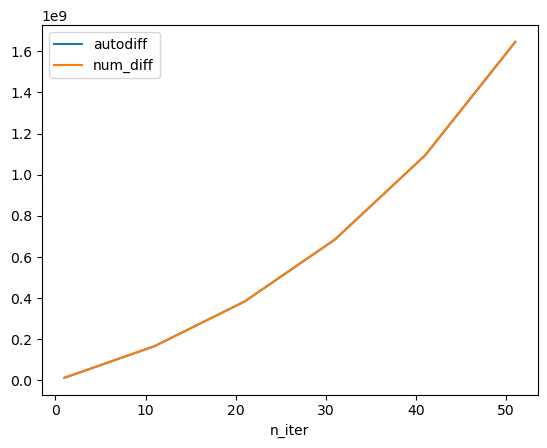

In [140]:
df.plot(x='n_iter')